# 8. Aurora model

In [3]:
import importlib
import pathlib
from tqdm import tqdm

import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pandas as pd

import astropy.units as u
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS, Galactic, Galactocentric

import matplotlib as mpl
import matplotlib.pyplot as plt

import config
import utils
from domain import Domain
from projector import Projector

In [4]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

In [10]:
# Metallicity limits
mh_lo_lim, mh_hi_lim = -3.0, -1.3

## Load everything

### Load domain

In [17]:
dom = Domain().load(cache_path / f"domain_hpx{config.model_hpx_order}_wholesky.npz")
hpx_nside = dom.nside
hpx_ipix  = dom.ipix
D_edgs = dom.D_
D  = dom.D
dD = dom.dD

hpx_order = int(np.log2(hpx_nside))
hpx_npix = 12 * 4**hpx_order
hpx_base = 2**35 * 4**(12 - hpx_order)

### Load projecting operator

In [44]:
proj = Projector().load(cache_path / f"projector_hpx{config.model_hpx_order}_wholesky.npz")

### Load RGB sample

In [62]:
usecols = ['source_id', 'l', 'b', 'dist', 'x', 'y', 'z', 'mh_xgboost']
df0 = pd.read_hdf(cache_path / 'rgb.hdf5', columns=usecols)
print("Num. of subsample stars:", len(df0))

Num. of subsample stars: 17558141


In [63]:
# Cut by [M/H]
mask = (mh_lo_lim <= df0['mh_xgboost']) & (df0['mh_xgboost'] < mh_hi_lim)
df = df0[mask]
print(f"Num. of subsample stars after selection:", len(df))
del(df0)

Num. of subsample stars after selection: 222319


In [64]:
df['hpx'] = df['source_id'] // hpx_base

### Load probability transformation function

In [28]:
res = np.load(cache_path / 'tf.npz')
TF  = res['TF']

print("shape(TF) =", np.shape(TF))
print("isnan(TF) =", np.any(np.isnan(TF)))
print("isnan(TF[hpx_ipix]) =", np.any(np.isnan(TF[hpx_ipix])))
del(res)

shape(TF) = (12288, 41, 41)
isnan(TF) = False
isnan(TF[hpx_ipix]) = False


## Estimate the observables

In [29]:
df['dist_bin'] = pd.cut(df['dist'], bins=D_edgs)
cnt0 = df.groupby(['hpx', 'dist_bin'], observed=False).size().reset_index(name='cnt')
cnt1 = cnt0.pivot(index='hpx', columns='dist_bin', values='cnt')
cnt2 = cnt1.merge(pd.Series(hpx_ipix, name='hpx'), how='right', on='hpx')
cnt2.fillna(0.0, inplace=True)
cnt2.drop(columns='hpx', inplace=True)
N_lbD = cnt2.values
print("shape(N_lbD) =", np.shape(N_lbD))

del(cnt0, cnt1, cnt2)

shape(N_lbD) = (12288, 41)


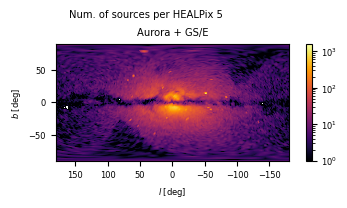

In [37]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 10/inch, 5/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle(f"Num. of sources per HEALPix {hpx_order}")

plt.gca().set_aspect('equal')
sky = np.nan * np.zeros(hpx_npix)
sky[hpx_ipix] = N_lbD.sum(axis=1)
utils.plot_hpxmap(sky, vmin=1.0, title="Aurora + GS/E")

plt.savefig(fig_path / 'obs_map.pdf', dpi=config.fig_dpi)
plt.show()
plt.close()

In [38]:
# Save the observables
np.savez_compressed(cache_path / 'N_lbD.npz', N_lbD=N_lbD)

## Run the model

### Prepare

In [46]:
# Load previous samples, if any
import phys_models
importlib.reload(phys_models)

sims_ = []
try:
    sims = pd.read_csv('model.csv')
    sims_ = sims.to_dict('records')
except FileNotFoundError:
    pass
len(sims_)

0

In [47]:
# Initialize GS/E model
fn_rho_gse = phys_models.Density_LBM23_AD_SC()

In [48]:
# Initialize the full density model
rho_gse = fn_rho_gse(proj.xyz[0], proj.xyz[1], proj.xyz[2])
fn_rho = phys_models.Density_tot_BPL(rho_gse)

### Maximize likelihood

All run results stored in 'model.csv'. The best run is stored in 'model_ast.csv'

In [75]:
b_min, b_max = 0.7, 2.0
s_min, s_max = 1.5, 2.5
k_1_min, k_1_max = 1.0, 5.0
q_1_min, q_1_max = 0.1, 20.0
k_2_min, k_2_max = 3.0, 8.0
xi_min, xi_max = 0.0003, 0.003

low  = [b_min, s_min, k_1_min, q_1_min, k_2_min, xi_min]
high = [b_max, s_max, k_1_max, q_1_max, k_2_max, xi_max]
bounds = list(zip(low, high))

niter = 100
for _ in tqdm(range(niter), total=niter):
    theta_0 = np.random.default_rng().uniform(low=low, high=high)

    # SciPy
    method = None
    #method = 'L-BFGS-B'
    res = minimize(fun=phys_models.loss_multinomial, x0=theta_0, tol=1e-6, bounds=bounds, args=(dom, proj, TF, fn_rho, N_lbD), method=method)

    sims_.append({'b_0': theta_0[0], 's_0': theta_0[1],
                  'k_1_0': theta_0[2], 'q_1_0': theta_0[3], 'k_2_0': theta_0[4], 'xi_0': theta_0[5],
                  'logL/N': -res.fun/N_lbD.sum(),
                  'b': res.x[0], 's': res.x[1],
                  'k_1': res.x[2], 'q_1': res.x[3], 'k_2': res.x[4], 'xi': res.x[5],
                  'N': N_lbD.sum()})
    sims = pd.DataFrame(sims_)

sims.to_csv('model.csv', mode='w', index=False)

print()
ast = pd.DataFrame(sims.iloc[sims['logL/N'].idxmax()]).T[['logL/N', 'b', 's', 'k_1', 'q_1', 'k_2', 'xi', 'N']]
ast.to_csv('model_ast.csv', mode='w', index=False)
print("ast:")
print(ast)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


ast:
        logL/N         b       s       k_1       q_1       k_2        xi  \
172 -11.356594  1.156159  2.0406  4.315492  3.291281  6.292868  0.001586   

            N  
172  222183.0  


## Plots

### Apply the best model

In [51]:
ast = pd.read_csv('model_ast.csv').iloc[0]
print("ast:\n", ast)
theta = ast[['b', 's', 'k_1', 'q_1', 'k_2', 'xi']].values
print("theta =", theta)

ast:
 logL/N       -11.356594
b              1.156159
s              2.040600
k_1            4.315492
q_1            3.291281
k_2            6.292868
xi             0.001586
N         222183.000000
Name: 0, dtype: float64
theta = [1.15615860e+00 2.04059986e+00 4.31549226e+00 3.29128052e+00
 6.29286784e+00 1.58586511e-03]


### Plot cuts

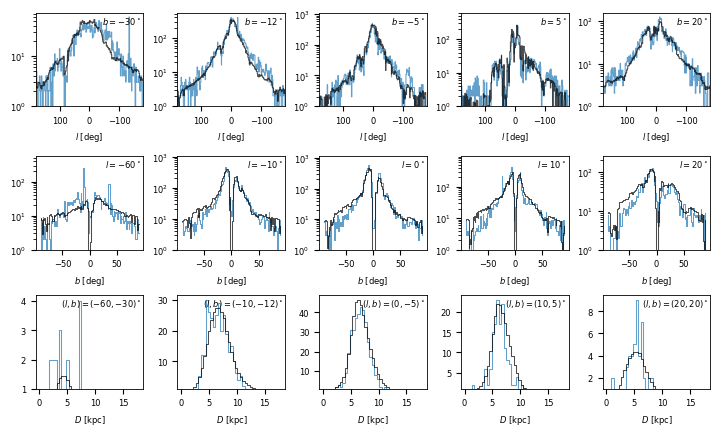

In [57]:
rho = fn_rho(proj.xyz[0], proj.xyz[1], proj.xyz[2], theta)
p = np.einsum('ijk,ik->ij', TF, rho)
p /= p.sum()
Q_lbD = N_lbD.sum() * p


step = 0.5
l_grid = np.arange(-180.0, 180.0, step)
b_grid = np.arange(-90.0, 90.0, step)
b_mesh, l_mesh = np.meshgrid(b_grid, l_grid)

hp = HEALPix(nside=hpx_nside, order='nested', frame='icrs')
co = SkyCoord(l_mesh, b_mesh, frame='galactic', unit='deg')
hpx = hp.skycoord_to_healpix(co)


plt.rc('font', size=6.0)
plt.rc('axes', linewidth=0.6)
plt.rc('legend', borderpad=0)
plt.rc('legend', borderaxespad=0.25)
plt.rc('lines', linewidth=0.75)
inch = 2.54  ## cm
width, height = 18/inch, 10.8/inch
plt.figure(figsize=(width, height), layout='constrained')

alpha = 0.7

bs = [-30, -12, -5, 5, 20]
ls = [-60, -10, 0, 10, 20]
co = SkyCoord(ls, bs, frame='galactic', unit='deg')
hp = HEALPix(nside=hpx_nside, order='nested', frame='icrs')
ipix_ = hp.skycoord_to_healpix(co)

for k, b_ in enumerate(bs):
    plt.subplot(3, len(bs), k+1)
    ib = np.argmin(b_grid < b_) - 1
    plt.step(l_grid, N_lbD[hpx[:,ib]].sum(axis=-1), where='mid', alpha=alpha, label=(r"$b={%g}^\circ$" % b_))
    plt.step(l_grid, Q_lbD[hpx[:,ib]].sum(axis=-1), c='k', where='mid', alpha=alpha)
    plt.legend(handlelength=0, loc='upper right', frameon=False)
    plt.xlabel(r"$l$ [deg]")
    plt.xlim(l_grid[-1], l_grid[0])
    plt.yscale('log')
    plt.ylim(ymin=1)

for k, l_ in enumerate(ls):
    plt.subplot(3, len(bs), len(bs)+k+1)
    il = np.argmin(l_grid < l_) - 1
    plt.step(b_grid, N_lbD[hpx[il,:]].sum(axis=-1), where='mid', alpha=alpha, label=(r"$l={%g}^\circ$" % l_))
    plt.step(b_grid, Q_lbD[hpx[il,:]].sum(axis=-1), c='k', where='mid', alpha=alpha)
    plt.legend(handlelength=0, loc='upper right', frameon=False)
    plt.xlabel(r"$b$ [deg]")
    plt.yscale('log')
    plt.ylim(ymin=1)

for k, i in enumerate(ipix_):
    plt.subplot(3, len(bs), 2*len(bs)+k+1)
    plt.step(D, N_lbD[i,:], where='mid', alpha=alpha, label=(r"$(l,b)=({%g}, {%g})^\circ$" % (ls[k], bs[k])))
    plt.step(D, Q_lbD[i,:], c='k', where='mid', alpha=alpha)
    plt.legend(handlelength=0, loc='upper right', frameon=False)
    plt.xlabel(r"$D$ [kpc]")
    #plt.yscale('log')
    plt.ylim(ymin=1)

plt.savefig(cache_path / 'model_cuts.pdf')
plt.show()
plt.close()

### Plot projections

/home/kurbatov/GaiaUnlimited/2023 Aurora/application-pipeline.git/notebooks/utils.py:178: RuntimeWarning: invalid value encountered in divide
  diff_lb = (dF_hist_lb - df_hist_lb) / (dF_hist_lb + df_hist_lb)
/home/kurbatov/GaiaUnlimited/2023 Aurora/application-pipeline.git/notebooks/utils.py:215: RuntimeWarning: invalid value encountered in divide
  diff_xy = (dF_hist_xy - df_hist_xy) / (dF_hist_xy + df_hist_xy)
/home/kurbatov/GaiaUnlimited/2023 Aurora/application-pipeline.git/notebooks/utils.py:252: RuntimeWarning: invalid value encountered in divide
  diff_xz = (dF_hist_xz - df_hist_xz) / (dF_hist_xz + df_hist_xz)


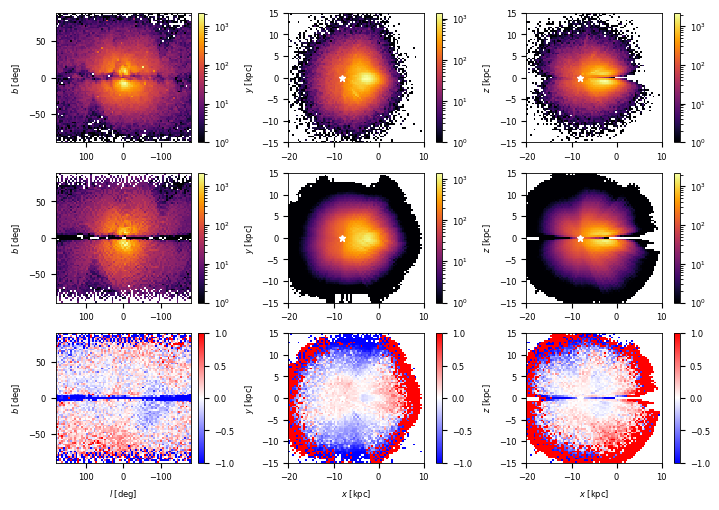

In [65]:
inch = 2.54  ## cm
width, height = 18/inch, 12.675/inch

utils.plot_final_pane(df, Q_lbD, dom, proj, xlim=(-20, 10), ylim=(-15, 15), zlim=(-15, 15),
                      figsize=(width, height), bins=75)

plt.savefig(cache_path / 'model-projections.pdf')
plt.show()
plt.close()

## Estimate mass of the Aurora and GS/E

### Normalize the densities

In [66]:
from scipy.stats import qmc

# More than enough
#r_min, r_max = 2.0, 70.0  # kpc
r_min, r_max = D_edgs[0], D_edgs[-1]
print("r_min, r_max =", r_min, r_max)
Vol_max = 4*np.pi/3 * r_max**3
Vol_min = 4*np.pi/3 * r_min**3
Vol = Vol_max - Vol_min

sampler = qmc.Sobol(d=3, scramble=False)
xyzT = sampler.random_base2(m=25)
xyzT = qmc.scale(xyzT, [-r_max, -r_max, -r_max], [r_max, r_max, r_max])
print(xyzT.shape)

mask = (r_min <= sp.linalg.norm(xyzT, axis=1)) & (sp.linalg.norm(xyzT, axis=1) <= r_max)
xyzT = xyzT[mask]
print(xyzT.shape)
n_samples = xyzT.shape[0]
print("n_samples =", n_samples)

x_, y_, z_ = xyzT[:,0], xyzT[:,1], xyzT[:,2]

xi = ast['xi']
print("xi =", xi)
rho_gse__ = fn_rho_gse(x_, y_, z_)
rho_au__  = fn_rho.fn(x_, y_, z_, theta)
rho__ = (1-xi)*rho_au__ + xi*rho_gse__

# MC the total model
C = n_samples/Vol / rho__.sum()
print("C =", C)
# PDF for the total population inside the r_max sphere
rho_ = C * rho__
print("? 1 ~", rho_.sum() * Vol/n_samples)
# Joint PDF for the Aurora inside the r_max sphere
rho_au_ = C * (1-xi)*rho_au__
f_M_au = rho_au_.sum() * Vol/n_samples
print("f_M_au =", f_M_au)
# Joint PDF for the GS/E inside the r_max sphere
rho_gse_ = C * xi*rho_gse__
f_M_gse = rho_gse_.sum() * Vol/n_samples
print("f_M_gse =", f_M_gse)

# Estimate the total PDF inside the r_max sphere
ph = pd.DataFrame({'x': x_, 'y': y_, 'z': z_, 'rho_gse': rho_gse_, 'rho_au': rho_au_, 'rho': rho_})
del(xyzT, x_, y_, z_, rho_gse__, rho_au__, rho__, rho_gse_, rho_au_, rho_)

# Estimate the total density in the model domain
rho = C * fn_rho(proj.xyz[0], proj.xyz[1], proj.xyz[2], theta)
rho_au  = C * (1-xi) * fn_rho.fn(proj.xyz[0], proj.xyz[1], proj.xyz[2], theta)
rho_gse = C * xi * fn_rho_gse(proj.xyz[0], proj.xyz[1], proj.xyz[2])

r_min, r_max = 0.01 18.0
(33554432, 3)
(17568694, 3)
n_samples = 17568694
xi = 0.0015858651072014
C = 0.014838447723113941
? 1 ~ 1.0000000000000009
f_M_au = 0.5591849760807592
f_M_gse = 0.4408150239192411


### Estimate the number of stars and the mass of a `true' sample, i.e. not affected by selection effects

In [69]:
# The model evidence
Z = np.einsum('ijk,ik->', TF, rho)
print("Z =", Z)

# Number of stars in the sample
N_dat_sample = int(N_lbD.sum())
# Number of stars in population (i.e. not affected by the selection effects)
N_pop_sample = int(N_dat_sample / Z)
# Number of stars in the Aurora
N_pop_au  = int(f_M_au * N_pop_sample)
# Number of stars in the GS/E
N_pop_gse = int(f_M_gse * N_pop_sample)

print("N_dat_sample =", N_dat_sample)
print("N_pop_sample =", N_pop_sample)
print("N_pop_au     =", N_pop_au)
print("N_pop_gse    =", N_pop_gse)

# Stellar mass on an isochrone of [Fe/H]=-2 and age 13 Gyr
# MIST isochrones are used for this
mass_frac = 142.6
# Mass of the entire population represented by the observes RGB stars
M_tot_sample = mass_frac * N_pop_sample
# Mass of the Aurora
M_tot_au  = f_M_au * M_tot_sample
# Mass of the GS/E
M_tot_gse = f_M_gse * M_tot_sample

print("mass_frac =", mass_frac)
print(f"M_tot_sample = {M_tot_sample:.2e} M_sun")
print(f"M_tot_au  = {M_tot_au:.2e} M_sun")
print(f"M_tot_gse = {M_tot_gse:.2e} M_sun")

Z = 0.0898082629184768
N_dat_sample = 222183
N_pop_sample = 2473970
N_pop_au     = 1383406
N_pop_gse    = 1090563
mass_frac = 142.6
M_tot_sample = 3.53e+08 M_sun
M_tot_au  = 1.97e+08 M_sun
M_tot_gse = 1.56e+08 M_sun


### Plot radial profiles

<Figure size 314.961x314.961 with 0 Axes>

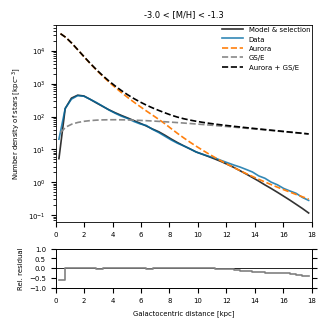

In [74]:
ph['r'] = np.sqrt(ph['x']**2 + ph['y']**2 + ph['z']**2)
ph['r_bins'] = pd.cut(ph['r'], D_edgs, right=False, include_lowest=True)
ph_r = ph.groupby('r_bins', observed=True, as_index=False).mean()


dVol = np.full_like(proj.xyz[0], dom.dVol)
proj.r = np.sqrt(proj.xyz[0]**2 + proj.xyz[1]**2 + proj.xyz[2]**2)

df = pd.DataFrame({'r': proj.r.flatten(), 'N': N_lbD.flatten(),
                   'dVol': dVol.flatten(),
                   'Q': Q_lbD.flatten()})
df['r_bins'] = pd.cut(df['r'], dom.D_, right=False, include_lowest=True)

df_r = df.groupby('r_bins', observed=True, as_index=False).sum()
rr = df.groupby('r_bins', observed=True, as_index=False)['r'].mean()
df_r['n'] = df_r['N'] / df_r['dVol']
df_r['q'] = df_r['Q'] / df_r['dVol']


plt.rc('font', size=5.0)
plt.rc('lines', linewidth=1.2)
inch = 2.54  ## cm
width, height = 8/inch, 8/inch
plt.figure(figsize=(width, height), layout='constrained')

mpl.style.use('tableau-colorblind10')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(width, height), layout='constrained', gridspec_kw={'height_ratios': [5, 1]})

alpha = 0.8

ax_ = ax0
ax_.set_title(f"{mh_lo_lim} < [M/H] < {mh_hi_lim}")
#
ax_.plot(D, df_r['q'], 'k', alpha=alpha, label="Model & selection")
#
ax_.plot(D, df_r['n'], c=colors[0], alpha=alpha, label="Data")
#
ax_.plot(ph_r['r'], N_pop_sample*ph_r['rho_au'], ls='--', c=colors[1], label="Aurora")
ax_.plot(ph_r['r'], N_pop_sample*ph_r['rho_gse'], ls='--', c=colors[6], label="GS/E")
ax_.plot(ph_r['r'], N_pop_sample*ph_r['rho'], ls='--', c='k', label="Aurora + GS/E")
#
ax_.legend(handlelength=3.0, frameon=False)
ax_.set_xlim(0.0, D_edgs[-1])
ax_.set_ylabel(r"Number density of stars [kpc$^{-3}$]")
ax_.set_yscale('log')

ax_ = ax1
ax_.axhline(0.0, c='k', lw=ax_.spines['top'].get_linewidth())
ax_.step(D, (df_r['q'] - df_r['n']) / (df_r['q'] + df_r['n']), where='post', c='gray')
ax_.set_xlabel(r"Galactocentric distance [kpc]")
ax_.set_xlim(0.0, D_edgs[-1])
ax_.set_ylabel("Rel. residual")
ax_.set_ylim(0.0, 1.0)
ax_.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax__ = ax_.twinx()
ax__.set_ylim(0.0, 1.0)
ax__.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax__.set_yticklabels([])

plt.savefig(fig_path / 'model-radial.pdf')
plt.show()
plt.close()